# SVM - Climate Sentiment Multiclass Classification
## CS522 Project

### Dataset: 
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

### Imports

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from cleanlab.classification import LearningWithNoisyLabels
from sklearn.ensemble import IsolationForest
from Common.DataCenter import data_center
from Common.preprocessor import normalize_preprocessing
from Common.UtilFuncs import print_evaluation, Evaluator

%matplotlib inline

Ev  = Evaluator()


### Text preprocessing

In [2]:
# parameter: original X of training set and test set
# return:  vectorised X of training set and test set
def text_preprocessing(X_train, X_test):
    # preprocessing with traditional NLP methodology
    X_train_normalized = normalize_preprocessing(X_train)
    X_test_normalized  = normalize_preprocessing(X_test)
    
    # vectorization
    # Convert texts to vectors by TFIDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X_train_vec  = vectorizer.fit_transform(X_train_normalized)
    X_test_vec   = vectorizer.transform(X_test_normalized)
      
    return X_train_vec, X_test_vec

### One-hot encoding, convert the labels to vectors (4 x 1) each

In [3]:
# parameter: original y of training set, original y of test set
# return:  encoded y of training set and test set
def one_hot_encoding(y_train, y_test):
    mlb          = MultiLabelBinarizer()
    y_train_vec  = mlb.fit_transform(map(str, y_train))
    y_test_vec   = mlb.transform(map(str, y_test))
    return y_train_vec, y_test_vec


### Run SVM

In [4]:
# parameter:  vectorised X and encoded y of training set and test set
def run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec):
    # Run SVM - fit and predict
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    SVM.fit(X_train_vec, y_train_vec)
    y_pred          = SVM.predict(X_test_vec)
    return  y_pred


### Do an experiment

In [5]:
# do an experiment without denoising
# Parameter: original X,y of training set and test set
# Return evaluation info
def do_experiment(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)
    
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    # Print the evaluation
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF

# do an experiment denoised by ConfidentLearning
# Parameter: training set and test set
# Return evaluation info, denoising info
def do_experiment_denoised_by_ConfidentLearning(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)
    
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # LearningWithNoisyLabels require the classifier has the entry predict_proba()
    # So, use CalibratedClassifierCV to wrap LinearSVC
    SVM = CalibratedClassifierCV(LinearSVC(dual=False, class_weight='balanced'))
    rp = LearningWithNoisyLabels(clf=SVM, seed=522)
    rp.fit(X_train_vec, np.array(y_train))
    y_pred = rp.predict(X_test_vec)

    # Print the evaluation
    # One hot encoding for print_evaluation()
    _, y_pred = one_hot_encoding(y_train, y_pred)
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])

    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF, None

# do an experiment denoised by IsolationForest
# Parameter: training set and test set
# Return evaluation info, denoising info
def do_experiment_denoised_by_IsolationForest(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)

    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    X = X_train_vec

    # IsolationForest
    # n_estimators is the number of trees, try bigger values
    iforest = IsolationForest(n_estimators=20000, max_samples='auto',
                              contamination=0.1, max_features=3,
                              bootstrap=False, n_jobs=-1, random_state=1)

    df = train_df.copy()
    df['label'] = iforest.fit_predict(X)

    # give the anomaly score
    df['scores'] = iforest.decision_function(X)
    df.sort_values(by="scores", inplace=True, ascending=True)

    denoisedDF = df[df.label!=-1]
    X_train, y_train = data_center.Xy(denoisedDF)

    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Ev.evaluate(y_test_vec, y_pred)

    return evaluateDF, denoisedDF


### Main entry
**The settings of the noise sources.**

In [6]:
# Each item: source -> (size, distribution)
noisy_set_sizes = {
    'mislabeled' : (8000, None),                   # max size: 15000
    'irrelevant' : (2000, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (2000, "reserve_labels"),       # max size: 5000
}


**Choose a denoising method**

In [7]:
# Each item: name -> (funcion, whether choose)
# note:only the first active one will be used. use 1 to active one
denoising_method = {
    'Confident Learning' : (do_experiment_denoised_by_ConfidentLearning, 0),
    'Isolation Forest'   : (do_experiment_denoised_by_IsolationForest,   1),
}


**Load the database and split it into training set, test set, noisy set, validation set**

In [8]:
# dc = data_center("twitter_sentiment_data_clean.csv", train_size = 20000, test_size = 4000, validation_size = 1000,
#                  noisy_size = noisy_set_sizes['mislabeled'][0] if 'mislabeled' in noisy_set_sizes.keys() else 0)

# Load the database and split it into training set, test set, noisy set, validation set
# Using noisy_set_sizes directly
dc = data_center("twitter_sentiment_data_clean.csv", train_size = 20000, test_size = 4000, validation_size = 1000,
                 noisy_size = noisy_set_sizes)


**Show the summary of the whole data**

In [9]:
dc.print_summary()


###################################### Data Summary #############################################
  Original set size: 40908
      sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
  Training set size: 20000
  Test set size: 4000
  Noisy set size: 12000
  Validation set size: 1000
      noise sources ('mislabeled', 'irrelevant', 'translated'): 66.7%, 16.7%, 16.7%
##################################################################################################


**To see the data features via a demo**

In [10]:
train_df = dc.get_train_with_noisy_df(1000,1000)
data_center.print_data(train_df.head(15))


,noise,noise_text,sentiment,origin(sentiment),tweetid(partial),message(partial)
0,1,mislabeled,3,2,794664,RT @ChelseaClinton: Thank you
1,0,none,3,-1,605804,Obama to follow Al Gore into c
2,2,irrelevant,1,-1,-1,This is a CGI animated film ba
3,0,none,2,-1,951653,umm ??? so itâ€™s basically su
4,1,mislabeled,0,2,848920,RT @Colorlines: POC who live t
5,1,mislabeled,1,3,798878,RT @ReutersLive: LIVE: U.S. Se
6,0,none,1,-1,840241,@bradcarlson_ not denying clim
7,0,none,2,-1,796429,RT @emmaroller: A climate chan
8,0,none,1,-1,793214,@michellemalkin Trump wins ele
9,0,none,3,-1,793175,Satellites help scientists see


**Get the test set for evaluation.**

In [11]:
test_df = dc.get_test_df()


**Set distributions of training set.**

In [12]:
# distribution of training set
# None represent it is same as the whole original data
train_distribution = None


**Run experiments with different training sets, and use the same test set.**
**Please wait some minutes until the finish message appears.**

In [13]:
expriment_no    = 1
print("-------------- No noisy training sets ----------")
for size in [2000, 4000, 5000, 8000, 10000, 15000, 20000]:
    # Get a training set without noisy data
    train_df = dc.get_train_df(size, train_distribution)
    print("*%2d> Training set size: %d samples" % (expriment_no, len(train_df)))
    data_center.print_distribution("  Sentiments", train_df['sentiment'])

    # Do an experiment
    dfResult = do_experiment(train_df, test_df)
    Ev.add_evaluation(dfResult, size, 0, "-",
                      data_center.calc_distribution_str(train_df['sentiment'], 'sentiment', [0,1,2,3]),
                      "-", expriment_no
                     )
    expriment_no += 1

print("-------------- Noisy training sets -------------")
# The noise source distribution of the whole noisy data.
dc.print_noise_source_distribution("General noise source distribution")

do_experiment_denoise  = None
for denoise_name, v in denoising_method.items():
    if v[1] == True:
        do_experiment_denoise = v[0]
        break
if do_experiment_denoise is None:
    print("No denoising function selected.")

lstSizes = [(4000, 1000), (8000, 2000), (15000, 5000)]
for size in lstSizes:
    # Get a noisy training set
    train_df         = dc.get_train_with_noisy_df(size[0], size[1], train_distribution)
    X_train, y_train = data_center.Xy(train_df)
    X_noisy          = train_df[train_df['noise'] != 0]

    print("*%2d> Noisy training set size: %d samples (%d original, %d noisy)"
          % (expriment_no, len(train_df), size[0], size[1]))
    data_center.print_distribution("  Sentiments", train_df['sentiment'])
    dc.print_noise_source_distribution("  Noise sources")

    # Do an experiment without de-noising
    print("  Before de-noising:")
    dfResult = do_experiment(train_df, test_df)
    Ev.add_evaluation(dfResult, size[0], size[1], "N",
                            data_center.calc_distribution_str(train_df['sentiment'], 'sentiment', [0,1,2,3]),
                            data_center.calc_distribution_str(X_noisy, 'noise', [1,2,3]),
                            expriment_no
                            )

    # Do an experiment with de-noising
    if do_experiment_denoise is None:
        continue

    print("  After de-noising:")
    dfResult, _ = do_experiment_denoise(train_df, test_df)

    Ev.add_evaluation(dfResult, size[0], size[1], "Y",
                            data_center.calc_distribution_str(train_df['sentiment'], 'sentiment', [0,1,2,3]),
                            data_center.calc_distribution_str(X_noisy, 'noise', [1,2,3]),
                            expriment_no + len(lstSizes)
                            )
    expriment_no += 1
    
print("-------------- Experiments are finished. -------------")    


-------------- No noisy training sets ----------
* 1> Training set size: 2000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.349, 0.315, 0.711, 0.678]
    micro_f1: 0.626 , macro_f1: 0.513 , weighted_f1: 0.597, macro_precision: 0.592, macro_recall: 0.504
* 2> Training set size: 4000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.442, 0.371, 0.741, 0.695]
    micro_f1: 0.657 , macro_f1: 0.562 , weighted_f1: 0.635, macro_precision: 0.623, macro_recall: 0.554
* 3> Training set size: 5000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.466, 0.4, 0.746, 0.709]
    micro_f1: 0.668 , macro_f1: 0.580 , weighted_f1: 0.648, macro_precision: 0.636, macro_recall: 0.570
* 4> Training set size: 8000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.521, 0.42, 0.758, 0.719]
  

**Show evaluations in a form (be sure the experiments have been finished)**

In [14]:
Ev.print()


,Origin,Noise,Denoised,Micro F1,Macro F1,Weighted F1,Macro Precision,Macro Recall,F1 of classes,Sentiments distribution,Noise sources distribution
Experiment,,,,,,,,,,,
1,2000,0,-,0.625651,0.513415,0.597445,0.591622,0.503592,"[0.349, 0.315, 0.711, 0.678]","[9.4%, 18.3%, 50.2%, 22.1%]",-
2,4000,0,-,0.657229,0.562267,0.634902,0.623003,0.553626,"[0.442, 0.371, 0.741, 0.695]","[9.4%, 18.3%, 50.2%, 22.1%]",-
3,5000,0,-,0.667753,0.580286,0.648046,0.636269,0.569531,"[0.466, 0.4, 0.746, 0.709]","[9.4%, 18.3%, 50.2%, 22.1%]",-
4,8000,0,-,0.682283,0.604498,0.665412,0.647677,0.597741,"[0.521, 0.42, 0.758, 0.719]","[9.4%, 18.3%, 50.2%, 22.1%]",-
5,10000,0,-,0.689442,0.614399,0.673934,0.645478,0.613033,"[0.534, 0.431, 0.765, 0.727]","[9.4%, 18.3%, 50.2%, 22.1%]",-
6,15000,0,-,0.701889,0.633075,0.687961,0.657390,0.636509,"[0.567, 0.452, 0.774, 0.74]","[9.4%, 18.3%, 50.2%, 22.1%]",-
7,20000,0,-,0.716268,0.654099,0.705114,0.668449,0.660337,"[0.599, 0.483, 0.788, 0.746]","[9.4%, 18.3%, 50.2%, 22.1%]",-
8,4000,1000,N,0.626698,0.545576,0.613819,0.594035,0.521799,"[0.413, 0.385, 0.707, 0.678]","[13.0%, 20.0%, 44.5%, 22.5%]","[67.6%, 15.7%, 16.7%]"
9,8000,2000,N,0.646983,0.573185,0.637710,0.604535,0.556002,"[0.463, 0.404, 0.73, 0.695]","[12.9%, 19.8%, 44.6%, 22.8%]","[67.0%, 16.4%, 16.6%]"


**Parameters for plotting.**

In [15]:
# Plot training set size vs. Macro F1
# x coordinate
xValue  = "x['Origin']+x['Noise']"
# also can try other numeric columns, like:
# xValue  = "x['Origin']"

# y coordinate
yValue  = "y['Macro F1']"
# also can try other numeric columns, like:
# yValue  = "y['Weighted F1']"
# yValue  = "y['Macro Precision']"

# Divide experiments into several groups, each will be plotted as a line
lines = { # each item: name, filter
    'Original Data':    "df['Denoised']=='-'",
    'Noisy Data':       "df['Denoised']=='N'",
    'Denoised Data':    "df['Denoised']=='Y'",
}


**Plot the evaluations.**

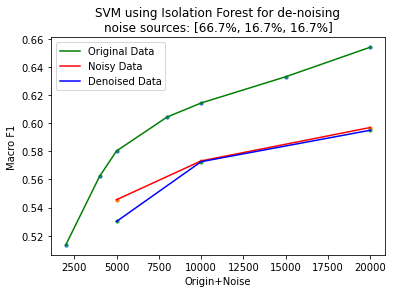

In [16]:
Ev.plot(xValue = xValue, yValue = yValue, lines = lines,
        title = 'SVM using %s for de-noising' % denoise_name,
        subtitle = data_center.distribution2str(
            "noise sources: ", dc.get_noise_source_distribution(), 3))
